In [1]:
import glob
import numpy as np
import oceanDAS as odas
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import date, datetime, timezone
from scipy import signal

%matplotlib inline
%cd -q '/Users/hglover/Library/CloudStorage/Box-Box/FiberExperiments/DAScomparison_paper/FlorenceOR_Ifju/'


In [2]:
def dispersion(h,T):
    # %
    # % [L,error,count] = dispersion(h,T);
    # % h=water depth(m), T=wave period (s)
    # % Numerically solves the linear dispersion relationship for water waves. 
    # % omega^2=gk*tanh(kh); where omega = 2*pi/T; k=2*pi/L; g=9.81;
    # % T and h provided as inputs.  Can handle T and/or h as vector inputs, for
    # % which the resulting size is L(m,n) for h(1,m) and T(1,n).
    # %
    # % Iterates using Newton-Raphson initialized with Guo (2002), which
    # % converges in under 1/2 the iterations of starting with deep water.
    # %
    # % Returns the error array and iteration count along with the wavelength.
    # %
    g = 9.81;
    omega = 2 * np.pi / T
    h = np.abs(h)

    # initial guess
    k = omega ** 2 / g * (1 - np.exp(-(omega * np.sqrt(h / g)) ** (5/2))) ** (-2/5)

    # iterate until error converges
    count = 0
    error = 1
    while np.any(error > (10 * np.finfo(float).eps)):
        f = omega ** 2 - g * k * np.tanh(k * h)
        dfdk = - g * np.tanh(k * h) - g * h * k * (1 / np.cosh(k * h)) ** 2
        k1 = k - f / dfdk
        error = abs((k1 - k) / k1)
        k = k1
        count += 1

    # wavelength
    L = 2 * np.pi / k;
    
    return L,k



def DAS_wave_conversion(das_data,fs,depth,strain_fac,strain_fac_frq,f_cutoff):
    #function to use simple pwelch to estimate wave spectra and bulk wave parameters for DAS data
    depth = np.abs(depth)
    nperseg = 512
    f_psd, ds_psd = signal.welch(das_data,fs=fs,nperseg=nperseg)

    # correct from PSD of strain to PSD of pressure
    C = np.interp(f_psd,strain_fac_frq,strain_fac)
    ds_psd *= C

    # cut off data above a precalculated noise floor frequency
    ds_psd[f_psd>f_cutoff] = np.nan
    
    # translate bed to surface
    L,_ = dispersion(depth,1/f_psd)
    attenuation = np.cosh((1/L)*depth)**2 # square for energy
    attenuation[attenuation>120] = np.nan; # cut it off when correction too big,don't amplify noise
    ds_psd_corr = ds_psd*attenuation

    # fill noise floor with f^-4 extrapolation:
    f_noise = f_psd[np.isnan(ds_psd_corr)]
    min_psd = np.min(ds_psd_corr[(f_psd>0.1) & (~np.isnan(ds_psd_corr))])
    ds_psd_corr[np.isnan(ds_psd_corr)] = (min_psd)*np.power(f_noise[0],4)*np.power(f_noise,-4)
    
    #calculate bulk wave characteristics
    ds_psd_corr = ds_psd_corr[(f_psd > 0.04) & (f_psd < 0.3)]
    f_psd = f_psd[(f_psd > 0.04) & (f_psd < 0.3)]
    fe = ((ds_psd_corr * f_psd) / ds_psd_corr.sum() ).sum() #(f*E)/E
    Te = 1/fe
    Tp = 1/(f_psd[np.argmax(ds_psd_corr)])

    bandwidth = (f_psd[1::] - f_psd[0:-1]).mean()
    Hs = 4*np.sqrt( ds_psd_corr.sum() * bandwidth ) 

    return Tp, Te, Hs

# function adapted from mms to calculate Hs, Tp, and Te from spectra of pressure in meters
def pres_wave_conversion(pressure,fs,depth):
    #function to use simple pwelch to estimate wave spectra and bulk wave parameters 
    #pwelch - defualt is 50% overlap hanning window
    depth = np.abs(depth)
    nperseg = 512
    f_psd, ds_psd = signal.welch(pressure,fs=fs,nperseg=nperseg)
    # translate bed to surface
    if depth==0:
        attenuation = 1
    else:    
        L,_ = dispersion(depth,1/f_psd)
        attenuation = np.cosh((1/L)*depth)**2 # square for energy
        attenuation[attenuation>120] = np.nan; # cut it off when correction too big,don't amplify noise
    ds_psd_corr = ds_psd*attenuation
    
    # fill noise floor with f^-4 extrapolation:
    f_noise = f_psd[np.isnan(ds_psd_corr)]
    min_psd = np.min(ds_psd_corr[(f_psd>0.1) & (~np.isnan(ds_psd_corr))])
    ds_psd_corr[np.isnan(ds_psd_corr)] = (min_psd)*np.power(f_noise[0],4)*np.power(f_noise,-4)
    
    #calculate bulk wave characteristics
    ds_psd_corr = ds_psd_corr[(f_psd > 0.04) & (f_psd < 0.3)]
    f_psd = f_psd[(f_psd > 0.04) & (f_psd < 0.3)]
    fe = ((ds_psd_corr * f_psd) / ds_psd_corr.sum() ).sum() #(f*E)/E
    Te = 1/fe
    Tp = 1/(f_psd[np.argmax(ds_psd_corr)])

    bandwidth = (f_psd[1::] - f_psd[0:-1]).mean()
    Hs = 4*np.sqrt( ds_psd_corr.sum() * bandwidth ) 
    
#     return f_psd, ds_psd, ds_psd_corr, Tp, Te, Hs
    return Tp, Te, Hs


In [3]:
# convert from phase to strain and downsample
# fname = 'mode9_0927_0930.npz'
# with np.load(fname) as data:
#     t = data['t']/1e6
#     rawstrain = data['r7009']

# fs=1000
# # decimate
# # step 1: filter HF signals 
# N = 4 # butterworth filter order
# Wn = 3 #cut off freq in Hz
# sos = signal.butter(N, Wn, btype='low', output='sos', fs=fs)
# rawstrain = signal.sosfiltfilt(sos, rawstrain)

# # step 2: downsample data and relevant variables
# rawstrain = rawstrain[::500]
# t = t[0::500]

# # calculate a moving average for each channel by LP filtering
# Wn = 1/(10*60) #0.002 #cut off freq in Hz
# sos = signal.butter(N, Wn, btype='low', output='sos', fs=fs)
# movMean = signal.sosfiltfilt(sos, rawstrain)


# scale_factor = (1550.12 * 1e-9)/(0.78 * 4 * np.pi * 1.46 * 6.38)

# rawstrain = (rawstrain-movMean)*scale_factor
# np.savez('downsamp_0927-0930_ch700',t=t,r7008=rawstrain)

In [4]:
# # load strain (near channel 700, h ~ 50) and pressure
# fname = 'adcp250_pressure.csv'
# f = np.genfromtxt(fname, delimiter=',')
# p_time = f[:,0]-(24*60*60)
# print(datetime.utcfromtimestamp(p_time[2046]))
# print(datetime.utcfromtimestamp(p_time[2047]))
# print(datetime.utcfromtimestamp(p_time[2048]))
# print(len(p_time))

# plt.figure()
# plt.plot(range(len(p_time)),p_time,'.')
# plt.xlim([2040,2060])
# plt.ylim([p_time[0],p_time[2200]])

In [5]:
# fname = 'adcp250_temperature.csv'
# f = np.genfromtxt(fname, delimiter=',')
# p_time = f[:,0]
# print(datetime.utcfromtimestamp(p_time[0]))
# print(datetime.utcfromtimestamp(p_time[1]))
# print(datetime.utcfromtimestamp(p_time[-1]))
# print(len(p_time))

In [6]:
# load strain (near channel 700, h ~ 50) and pressure
# Something is wrong with the time in the pressure csv - its a time zone offset... :/
fname = 'adcp250_pressure.csv'
f = np.genfromtxt(fname, delimiter=',')
p_time = f[:,0]+(8*60*60)
p = f[:,1]
p_fs = 1 #1 Hz
print(datetime.utcfromtimestamp(p_time[0]))
print(datetime.utcfromtimestamp(p_time[-1]))

fname = 'downsamp_0927-0930_ch700.npz'
with np.load(fname) as data:
    das_time = data['t']
    rawstrain = data['r7008']
depth = 50 # from metadata
fs = 2
tvec = mdates.date2num((das_time)*1e+6)
# ns = len(rawstrain)
print(datetime.utcfromtimestamp(das_time[0]))
print(datetime.utcfromtimestamp(das_time[-1]))


fname = 'ndbc46229.csv'
f = np.genfromtxt(fname, delimiter=',',skip_header=2)
L = len(f[:,0])
buoy_time = np.empty(L)
for jj in range(L):
    buoy_time[jj]  = datetime(int(f[jj,0]), int(f[jj,1]), int(f[jj,2]), int(f[jj,3]), int(f[jj,4]), 0,
                             tzinfo=timezone.utc).timestamp()

buoy_hs = f[:,5]
buoy_tp = f[:,6]
buoy_time = mdates.date2num((buoy_time)*1e+6)

2022-09-24 15:18:52.334400
2022-10-06 07:52:59.334400
2022-09-27 22:48:09.803000
2022-10-01 00:02:44.337000


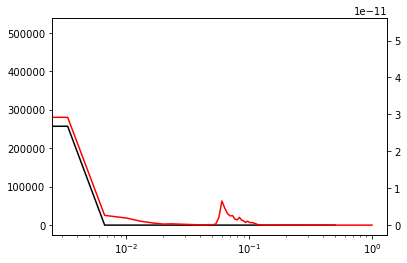

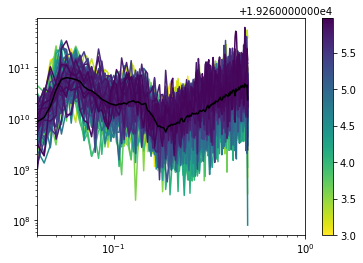

In [7]:

# example calculation for a single hour:
# calculate a frequency dependent strain factor by comparing spectra of strain and pressure
numvals = 60*30
t1 = datetime(2022, 9, 28, 0, 0, 0,tzinfo=timezone.utc).timestamp()
t2 = datetime(2022, 10, 1, 0, 0, 0,tzinfo=timezone.utc).timestamp()
idx = np.arange(t1,t2,60*30)
L = len(idx)

frqP, psd_p = signal.welch(p[(p_time>=t1) & (p_time<(t1+numvals))], fs=p_fs, window='hann', nperseg=5*60*p_fs,detrend=False)
frqS, psd_strain = signal.welch(rawstrain[(das_time>=t1) & (das_time<(t1+numvals))], fs=fs, window='hann', nperseg=5*60*fs,detrend=False)

# psd_p[frqP<0.04]=np.nan
# psd_strain[frqS<0.04]=np.nan

fig,ax = plt.subplots(1,1)
ax.plot(frqP,psd_p,'k')
ax2 = ax.twinx()
ax2.plot(frqS, psd_strain,'r')
ax.set_xscale('log')

psd_strain = np.interp(frqP,frqS,psd_strain)
strain_fac = psd_p/psd_strain

plotTime = mdates.date2num((idx)*1e+6)
color = iter(plt.cm.viridis_r(np.linspace(0, 1, len(idx))))


plt.figure()
for jj in range(1,L-1):
    frqS , psd_strain = signal.welch(rawstrain[(das_time>=idx[jj]) & (das_time<(idx[jj]+numvals))], fs=fs, window='hann', nperseg=5*60*fs,detrend=False)
    psd_strain = np.interp(frqP,frqS,psd_strain)

    frqP, psd_p = signal.welch(p[(p_time>=idx[jj]) & (p_time<(idx[jj]+numvals))], fs=p_fs, window='hann', nperseg=5*60*p_fs,detrend=False)
    temp = psd_p/psd_strain
    temp[(frqP<0.04) | (frqP>0.55)] = np.nan
    strain_fac = np.vstack([strain_fac,temp])
    line_c = next(color)
    plt.plot(frqP,temp.T,c=line_c)
strain_fac_mean = np.median(strain_fac,axis=0)
sm = plt.cm.ScalarMappable(cmap='viridis_r', norm=plt.Normalize(vmin=min(plotTime), vmax=max(plotTime)))
cbar = plt.colorbar(sm)
cbar.ax.xaxis.set_major_formatter(mdates.DateFormatter('%d'))


plt.plot(frqP,strain_fac_mean,'k')
plt.xscale('log')
plt.yscale('log')
plt.xlim([0.04,1])
# plt.ylim([0,1e14])
strain_fac_mean=strain_fac_mean[frqP<0.25]
frqP=frqP[frqP<0.25]

# np.savez('straincorrfac700', c = strain_fac_mean, f = frqP)

/var/folders/p0/vpgr0c8j2493xrh10b954hv40000gn/T/ipykernel_5511/2691935484.py:54: RuntimeWarning: divide by zero encountered in true_divide
  L,_ = dispersion(depth,1/f_psd)
/var/folders/p0/vpgr0c8j2493xrh10b954hv40000gn/T/ipykernel_5511/2691935484.py:20: RuntimeWarning: divide by zero encountered in power
  k = omega ** 2 / g * (1 - np.exp(-(omega * np.sqrt(h / g)) ** (5/2))) ** (-2/5)
/var/folders/p0/vpgr0c8j2493xrh10b954hv40000gn/T/ipykernel_5511/2691935484.py:20: RuntimeWarning: invalid value encountered in multiply
  k = omega ** 2 / g * (1 - np.exp(-(omega * np.sqrt(h / g)) ** (5/2))) ** (-2/5)
/var/folders/p0/vpgr0c8j2493xrh10b954hv40000gn/T/ipykernel_5511/2691935484.py:62: RuntimeWarning: divide by zero encountered in power
  ds_psd_corr[np.isnan(ds_psd_corr)] = (min_psd)*np.power(f_noise[0],4)*np.power(f_noise,-4)
/var/folders/p0/vpgr0c8j2493xrh10b954hv40000gn/T/ipykernel_5511/2691935484.py:62: RuntimeWarning: invalid value encountered in multiply
  ds_psd_corr[np.isnan(ds_psd

(19263.0, 19265.979166666668)

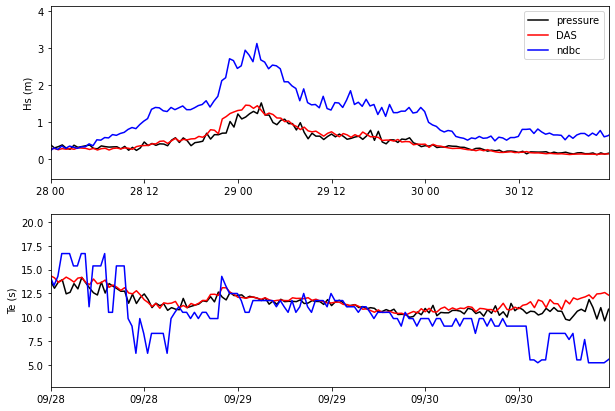

In [8]:
Tp_Das = np.empty([L])
Te_Das = np.empty([L])
Hs_Das = np.empty([L])
Tp_Pre = np.empty([L])
Te_Pre = np.empty([L])
Hs_Pre = np.empty([L])


for jj in range(L):
    temp = rawstrain[(das_time>idx[jj]) & (das_time<(idx[jj]+numvals))]
    Tp_Das[jj], Te_Das[jj], Hs_Das[jj] = DAS_wave_conversion(temp,fs,depth,strain_fac_mean,frqP,0.26)
    Tp_Pre[jj], Te_Pre[jj], Hs_Pre[jj] = pres_wave_conversion(p[(p_time>idx[jj]) & (p_time<(idx[jj]+numvals))],p_fs,depth)



fig, ax = plt.subplots(2,1,figsize=(10,7))
ax[0].plot(plotTime,Hs_Pre,'k',label='pressure')
ax[0].plot(plotTime,Hs_Das,'r',label='DAS ')
ax[0].plot(buoy_time,buoy_hs-1,'b',label='ndbc')
ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%d %H'))
ax[0].set_ylabel('Hs (m)')
ax[0].legend()
ax[0].set_xlim([plotTime[0],plotTime[-1]])

ax[1].plot(plotTime,Te_Pre,'k')
ax[1].plot(plotTime,Te_Das,'r')
ax[1].plot(buoy_time,buoy_tp,'b')
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
ax[1].set_ylabel('Te (s)')
ax[1].set_xlim([plotTime[0],plotTime[-1]])

In [9]:
# calculate a best fit between the Hs and Tp values to get r2 and mse
mask = np.isfinite(Tp_Pre) & np.isfinite(Tp_Das)
corr = np.corrcoef(Tp_Pre[mask], Tp_Das[mask])
r2_tp = corr[0,1]**2
rmse_tp = np.sqrt(np.mean((Tp_Das[mask]-Tp_Pre[mask])**2))
mask = np.isfinite(Hs_Pre) & np.isfinite(Hs_Das)
corr = np.corrcoef(Hs_Pre[mask], Hs_Das[mask])
r2_hs = corr[0,1]**2
rmse_hs = np.sqrt(np.mean((Hs_Das[mask]-Hs_Pre[mask])**2))

mask = np.isfinite(Te_Pre) & np.isfinite(Te_Das)
corr = np.corrcoef(Te_Pre[mask], Te_Das[mask])
r2_te = corr[0,1]**2
rmse_te = np.sqrt(np.mean((Te_Das[mask]-Te_Pre[mask])**2))


np.savez('empCal_Ch700_Flo_f1.npz',
        sf=strain_fac_mean,frq=frqP,
        r2_tp=r2_tp,rms_tp=rmse_tp,
        r2_te=r2_te,rms_te=rmse_te,
        r2_hs=r2_hs,rms_hs=rmse_hs,
        tp_das=Tp_Das, te_das=Te_Das, hs_das=Hs_Das,
        tp_pre=Tp_Pre, te_pre=Te_Pre, hs_pre=Hs_Pre)


print(rmse_te,rmse_tp,rmse_hs)
print(len(plotTime))
print(min(Te_Das),max(Te_Das))
print(min(Hs_Das),max(Hs_Das))
# fig, ax = plt.subplots(2,1,figsize=(7,10))    
# x = np.arange(0,4,1)
# # p = ax[0].scatter(Hs_Pre,Hs_Das,c=meanDir,vmin=35,vmax=105,cmap='coolwarm')
# p = ax[0].scatter(Hs_Pre,Hs_Das,c=meanDir,vmin=0,vmax=40)
# ax[0].plot(x,x,'k--')
# cbar = plt.colorbar(p,ax=ax[0])
# cbar.set_label('mean wave angle (o)')
# ax[0].set_xlabel('H_s from AWAC')
# ax[0].set_ylabel('H_s from DAS')
# ax[0].set_xlim([0,2.5])
# ax[0].set_ylim([0,2.5])

# p = ax[1].scatter(Te_Pre,Te_Das,c=meanDir,vmin=0,vmax=40)
# x = np.arange(0,19,1)
# ax[1].plot(x,x,'k--')
# cbar = plt.colorbar(p,ax=ax[1])
# cbar.set_label('mean wave angle (o)')
# ax[1].set_xlabel('T_e from AWAC')
# ax[1].set_ylabel('T_e from DAS')
# ax[1].set_xlim([3,14])
# ax[1].set_ylim([3,14])


0.7328184281911809 1.861804715249045 0.1069759960006932
144
10.246938610575176 14.353708752533514
0.13334688941774167 1.4618462179691556
